# Практика по базовой математической статистике для Data scientist

# Практика 3 - построение доверительной оценки

На практическом занятии научимся строить доверительные интервалы и выделять аномалии при помощи python.

- Строим доверительный интервал для цен акций из yahoo finance при помощи scipy, numpy, pandas
-  Делаем выводы по наличию или отсутствию аномальных событий

Для начала импортируем все полезные библитеки и настроим ноутбук

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
from scipy import *
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

В этой практике мы поработаем с реальными финансовыми данными.
Наверняка каждый из нас хоть раз покупал доллары в надежде немного заработать на разнице курсов покупки и продажи. Но не каждый знает, что помимо валют есть ещё и другие финансовые инструменты - например, акции или облигации, с которыми работают профессиональные инвесторы на специальной площадке для купли и продаже - бирже.

Данные о ценах финансовых инструментов называются котировками, и сегодня мы с вами представим себя инвесторами и проанализируем реальные котировки самых настоящих акций.

Мы будем доставать их из сервиса yahoo finance, и для этого помощи bash магии установим несколько нужных библиотек.

In [25]:
%%bash
pip install yfinance

Couldn't find program: 'bash'


In [26]:
%%bash
pip install pandas-datareader

Couldn't find program: 'bash'


In [27]:
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf

In [28]:
# Собираем котировки за интересующий период.
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 8, 31)

In [29]:
df = yf.download("GOOG", start=start_date, end=end_date)

Failed to get ticker 'GOOG' reason: HTTPSConnectionPool(host='fc.yahoo.com', port=443): Max retries exceeded with url: / (Caused by ProxyError('Unable to connect to proxy', OSError('Tunnel connection failed: 407 Proxy Authentication Required ( Forefront TMG requires authorization to fulfill the request. Access to the Web Proxy filter is denied.  )')))
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['GOOG']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       0 non-null      float64
 1   High       0 non-null      float64
 2   Low        0 non-null      float64
 3   Close      0 non-null      float64
 4   Adj Close  0 non-null      float64
 5   Volume     0 non-null      float64
dtypes: float64(6)
memory usage: 0.0+ bytes


In [31]:
# Переведем заголовки столбцов в нижний регистр и посмотрим на данные
df.columns = map(str.lower, df.columns)
df.head()

,open,high,low,close,adj close,volume
Date,,,,,,


Для изучения выберем разницу между ценой закрытия и ценой открытия.

In [32]:
# Готовим новую метрику.
df["diff_price"] = df.close - df.open

Для построения доверительного интервала необходимо, чтобы исследумая величина была распределена по Гауссову закону.
Поэтому воспользуемся функцией из первой практики для разведочного анализа.

Text(0.5, 1.0, 'График разницы между ценой закрытия и открытия')

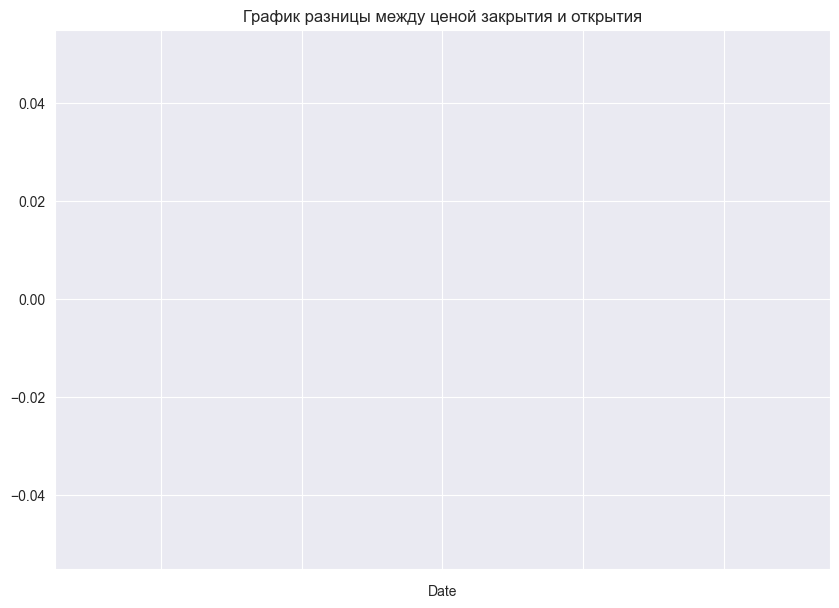

In [33]:
df.diff_price.plot()
plt.title("График разницы между ценой закрытия и открытия")

In [34]:
def my_basic_research(df=df, column = "diff_price"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")

    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")

    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))

    sns.distplot(df[column])
    plt.title("Распределение метрики")

Базовые метрики
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: diff_price, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
Series([], Name: count, dtype: int64)
------------------------------------
Эксцесс  nan
Ассиметрия  nan


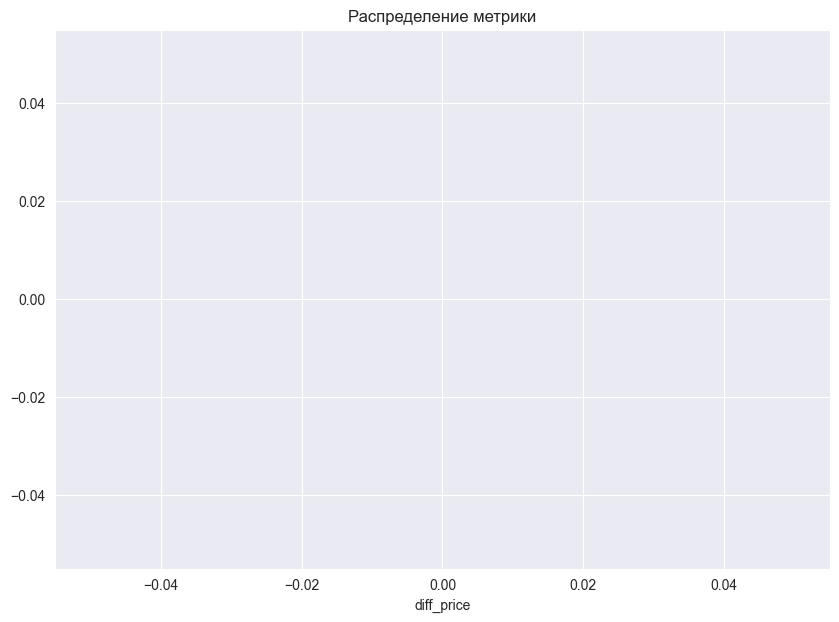

In [35]:
my_basic_research(column = "diff_price")

В целом наше распределение близко к нормальному, несмотря на остроконечный пик и наличие выбросов.
Однако для уверенности проверим его при помощи графика QQ plot - https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot

График сравнивает квантили выборки и выбранноого распределения - в нашем случае, нормального.

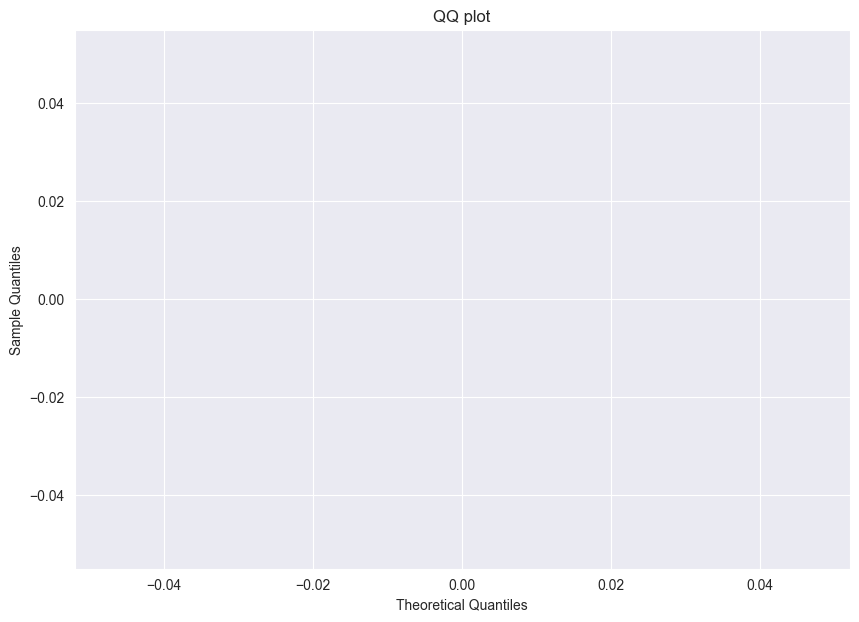

In [36]:
sm.qqplot(df.diff_price, fit = True)
plt.title("QQ plot")
plt.show()

Кажется, что можно использовать стандартные доверительные интервалы для нормального распределения. Для этого воспользуемся функцией https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [37]:
def my_norm_confidence(df=df, column = "diff_price", alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [38]:
confidence = my_norm_confidence()
print(confidence)

(nan, nan)


При доверительной вероятности 95 % средняя разница между ценой закрытия и открытия не выйдет за этот интервал.
Отметим на графике полученный коридор.

Text(0.5, 1.0, 'Доверительный интервал')

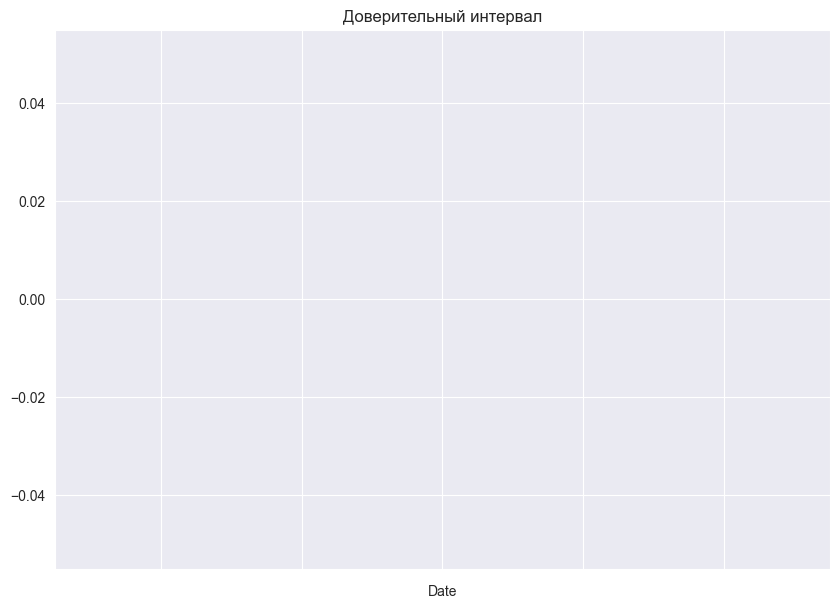

In [39]:
df.diff_price.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

## Отбор аномалий при помощи доверительного интервала

А если нам понадобится отметить аномальные события, выходящие за зеленую границу, то это можно сделать следующим образом

In [40]:
df["anomaly_big"] = np.where(df.diff_price > confidence[1], 1,0)

Теперь они готовы к дальнейшему исследованию.

In [41]:
df[df.anomaly_big == 1].describe()

,open,high,low,close,adj close,volume,diff_price,anomaly_big
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Мини домашка

Необходимо построить для тех же данных доверительный интервал с доверительной вероятностью 90 %
Сколько аномальных событий находится выше верхней доверительной границы?